In [58]:
# Import modules for our task

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
# Import system libraries and our Scripts

import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from user_overview_script import UserOverviewScript
from df_cleaning import DataFrameCleaning
from df_info import DataFrameInfo
from df_outlier import *
from plots import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Read cleaned Telecom dataset

cleaned_df = pd.read_csv('../data/cleaned_Telecom_data.csv')
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      148506 non-null  int64  
 1   Unnamed:_0                      148506 non-null  int64  
 2   Bearer_Id                       148506 non-null  float64
 3   Start                           148506 non-null  object 
 4   Start_ms                        148506 non-null  float64
 5   End                             148506 non-null  object 
 6   End_ms                          148506 non-null  float64
 7   Dur._(ms)                       148506 non-null  float64
 8   IMSI                            148506 non-null  float64
 9   MSISDN_Number                   148506 non-null  float64
 10  IMEI                            148506 non-null  float64
 11  Last_Location_Name              148506 non-null  object 
 12  Avg_RTT_DL_(ms) 

### **Task 3** - User Experience Analytics
**Task 3.1.** - Aggregate, per customer, the following information(treat missing & outliers by replacing by the mean or the mode of the corresponding variable

In [13]:
user_experience_df = cleaned_df[[
    "MSISDN_Number",
    "Avg_RTT_DL_(ms)",
    "Avg_RTT_UL_(ms)",
    "Avg_Bearer_TP_DL_(kbps)",
    "Avg_Bearer_TP_UL_(kbps)",
    "Handset_Type"]].copy()

In [14]:
# Instantiate UserOverViewScript class in user_overview_script 

user_overview_script = UserOverviewScript(user_experience_df)

In [15]:
# Convert Average RTT millisecond values to sec

user_experience_df['Avg_RTT_DL_(ms)'] = user_overview_script.convert_ms_to_sec(\
    user_experience_df['Avg_RTT_DL_(ms)'])

user_experience_df['Avg_RTT_UL_(ms)'] = user_overview_script.convert_ms_to_sec(\
    user_experience_df['Avg_RTT_UL_(ms)'])

In [16]:
# Bring back the deleted TCP Retransmission volume column during data cleaning from the original data 

df = pd.read_csv('../data/Week1_challenge_data_source(CSV).csv')
user_experience_df['TCP_DL_Retrans_Vol_(Bytes)'] = df['TCP DL Retrans. Vol (Bytes)']
user_experience_df['TCP_UL_Retrans_Vol_(Bytes)'] = df['TCP UL Retrans. Vol (Bytes)']

In [17]:
user_experience_df['TCP_DL_Retrans_Vol_(Bytes)'] = user_overview_script.convert_bytes_to_kbytes(\
    user_experience_df['TCP_DL_Retrans_Vol_(Bytes)'])

user_experience_df['TCP_UL_Retrans_Vol_(Bytes)'] = user_overview_script.convert_bytes_to_kbytes(\
    user_experience_df['TCP_UL_Retrans_Vol_(Bytes)'])

In [18]:
user_experience_df.rename(columns = {\
        'Avg_RTT_DL_(ms)':'Avg_RTT_DL_(sec)',\
        'Avg_RTT_UL_(ms)':'Avg_RTT_UL_(sec)',\
        'TCP_DL_Retrans_Vol_(Bytes)':'TCP_DL_Retrans_Vol_(kbps)',\
        'TCP_UL_Retrans_Vol_(Bytes)':'TCP_UL_Retrans_Vol_(kbps)'
    }, inplace=True)

##### Check for Null Values

In [19]:
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN_Number              148506 non-null  float64
 1   Avg_RTT_DL_(sec)           148506 non-null  float64
 2   Avg_RTT_UL_(sec)           148506 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)    148506 non-null  float64
 4   Avg_Bearer_TP_UL_(kbps)    148506 non-null  float64
 5   Handset_Type               148506 non-null  object 
 6   TCP_DL_Retrans_Vol_(kbps)  61271 non-null   float64
 7   TCP_UL_Retrans_Vol_(kbps)  52879 non-null   float64
dtypes: float64(7), object(1)
memory usage: 9.1+ MB


##### Treat Null Values

In [20]:
# Handle null values of TCP Retransmission volume columns with mean and median based on Skewness value 

user_experience_df = DataFrameCleaning(user_experience_df)
columns = ['TCP_DL_Retrans_Vol_(kbps)', 'TCP_UL_Retrans_Vol_(kbps)']
user_experience_df.fill_numerical_column(columns)

Automation in Action...!!!


In [21]:
# Count null values if any

user_experience_df = DataFrameInfo(user_experience_df.df)
user_experience_df.get_null_counts()

MSISDN_Number                0
Avg_RTT_DL_(sec)             0
Avg_RTT_UL_(sec)             0
Avg_Bearer_TP_DL_(kbps)      0
Avg_Bearer_TP_UL_(kbps)      0
Handset_Type                 0
TCP_DL_Retrans_Vol_(kbps)    0
TCP_UL_Retrans_Vol_(kbps)    0
dtype: int64


In [22]:
# Convert dataframe object to dataframe

user_experience_df = user_experience_df.df

In [24]:
user_experience_df['Total_Avg_RTT'] = user_experience_df['Avg_RTT_DL_(sec)'] + \
                                      user_experience_df['Avg_RTT_UL_(sec)']

user_experience_df['Total_Avg_Bearer_TP'] = user_experience_df['Avg_Bearer_TP_DL_(kbps)'] + \
                                      user_experience_df['Avg_Bearer_TP_UL_(kbps)']

user_experience_df['Total_Avg_TCP'] = user_experience_df['TCP_DL_Retrans_Vol_(kbps)'] + \
                                      user_experience_df['TCP_DL_Retrans_Vol_(kbps)']
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN_Number              148506 non-null  float64
 1   Avg_RTT_DL_(sec)           148506 non-null  float64
 2   Avg_RTT_UL_(sec)           148506 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)    148506 non-null  float64
 4   Avg_Bearer_TP_UL_(kbps)    148506 non-null  float64
 5   Handset_Type               148506 non-null  object 
 6   TCP_DL_Retrans_Vol_(kbps)  148506 non-null  float64
 7   TCP_UL_Retrans_Vol_(kbps)  148506 non-null  float64
 8   Total_Avg_RTT              148506 non-null  float64
 9   Total_Avg_Bearer_TP        148506 non-null  float64
 10  Total_Avg_TCP              148506 non-null  float64
dtypes: float64(10), object(1)
memory usage: 12.5+ MB


In [25]:
user_experience_agg = user_experience_df.groupby('MSISDN_Number').agg({
    'Total_Avg_RTT': 'sum',
    'Total_Avg_Bearer_TP': 'sum',
    'Total_Avg_TCP': 'sum',
    'Handset_Type': [lambda x: x.mode()[0]]})

user_experience = pd.DataFrame(columns=[
    "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP",
    "Handset_Type"])

user_experience["Total_Avg_RTT"] = user_experience_agg["Total_Avg_RTT"]['sum']
user_experience["Total_Avg_Bearer_TP"] = user_experience_agg["Total_Avg_Bearer_TP"]['sum']
user_experience["Total_Avg_TCP"] = user_experience_agg["Total_Avg_TCP"]['sum']
user_experience["Handset_Type"] = user_experience_agg["Handset_Type"]['<lambda>']
user_experience.head()

,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP,Handset_Type
MSISDN_Number,,,,
33601001722.00,0.05,76.00,84998.41,Huawei P20 Lite Huawei Nova 3E
33601001754.00,0.03,99.00,1119.76,Apple iPhone 7 (A1778)
33601002511.00,0.05,97.00,1119.76,undefined
33601007832.00,0.08,248.00,366.24,Apple iPhone 5S (A1457)
33601008617.00,0.12,56844.00,1858.68,Apple iPhone Se (A1723)


##### Treat Outliers

<AxesSubplot:>

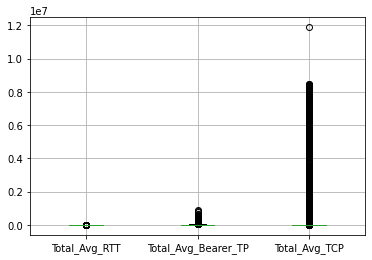

In [26]:
user_experience.boxplot()

<AxesSubplot:>

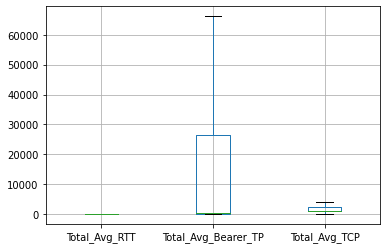

In [27]:
# Remove Outliers

replace_outliers_with_iqr(user_experience, ['Total_Avg_RTT', 'Total_Avg_Bearer_TP', 'Total_Avg_TCP'])
user_experience.boxplot()

#### **Task 3.2.**
Compute & list 10 of the top, bottom and most frequent:
* TCP values in the dataset. 
* RTT values in the dataset.
* Throughput values in the dataset.


#### Sort Dataset by TCP Values 

In [28]:
sorted_by_tcp = user_experience_df.sort_values(
    'Total_Avg_TCP', ascending=False)
top_10 = sorted_by_tcp.head(10)['Total_Avg_TCP']
last_10 = sorted_by_tcp.tail(10)['Total_Avg_TCP']
most_10 = user_experience_df['Total_Avg_TCP'].value_counts().head(10)

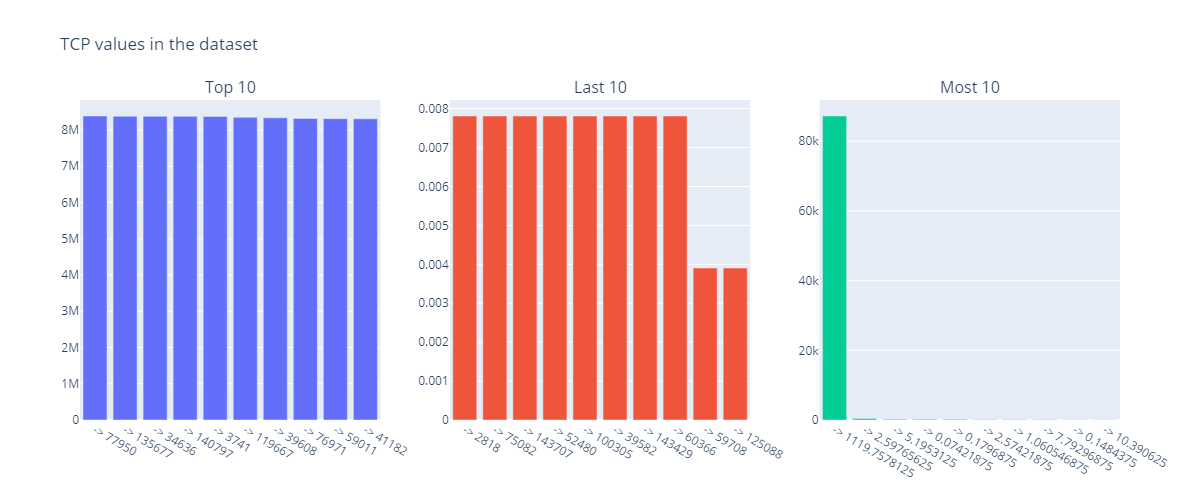

In [29]:
mult_hist([top_10, last_10, most_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

#### Sort Dataset by RTT Values 

In [32]:
sorted_by_RTT = user_experience_df.sort_values(
    'Total_Avg_RTT', ascending=False)
top_10 = sorted_by_RTT.head(10)['Total_Avg_RTT']
last_10 = sorted_by_RTT.tail(10)['Total_Avg_RTT']
most_10 = user_experience_df['Total_Avg_RTT'].value_counts().head(10)

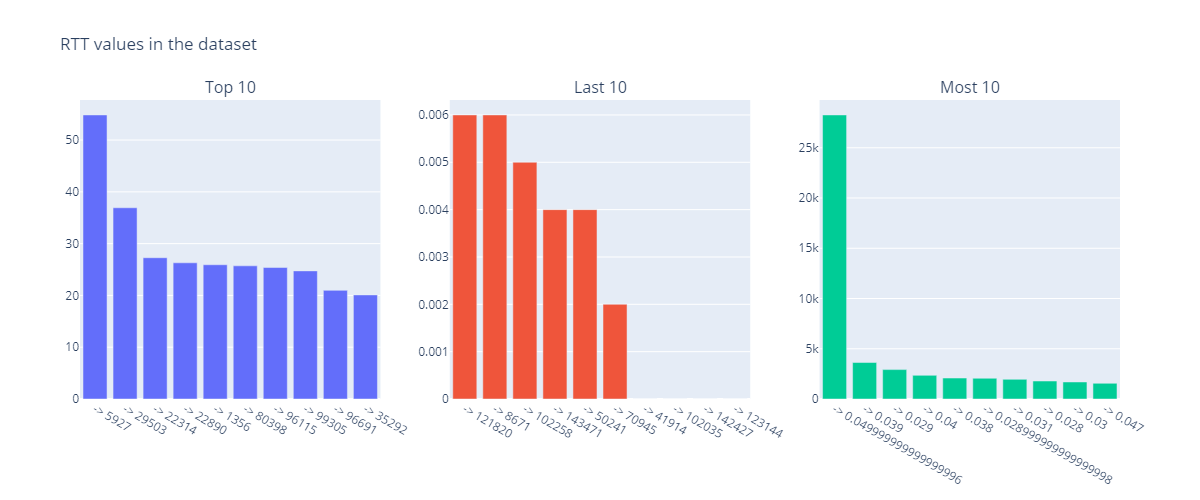

In [33]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "RTT values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

#### Sort Dataset by Throughput Values 

In [34]:
sorted_by_Bearer_TP = user_experience_df.sort_values(
    'Total_Avg_Bearer_TP', ascending=False)
top_10 = sorted_by_Bearer_TP.head(10)['Total_Avg_Bearer_TP']
last_10 = sorted_by_Bearer_TP.tail(10)['Total_Avg_Bearer_TP']
most_10 = user_experience_df['Total_Avg_Bearer_TP'].value_counts().head(10)

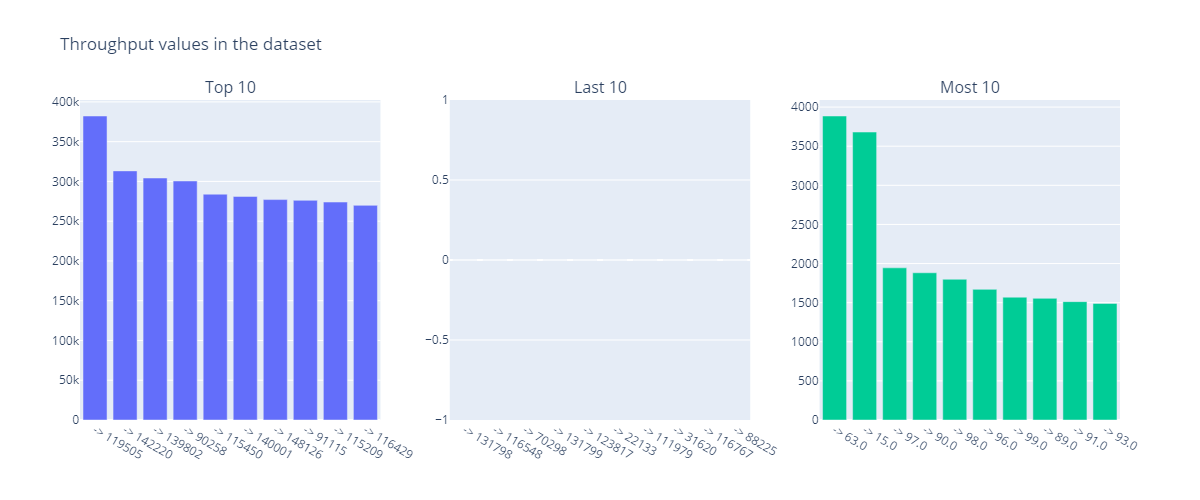

In [35]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "Throughput values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

#### **Task 3.3.** 
* Compute the distribution of the average throughput  per handset type 
* Compute the average TCP retransmission view per handset type 


In [36]:
handset_type_agg = user_experience_df.groupby('Handset_Type').agg(
    {'Total_Avg_Bearer_TP': 'mean', 'Total_Avg_TCP': 'mean'})
handset_type_agg.head()

,Total_Avg_Bearer_TP,Total_Avg_TCP
Handset_Type,,
A-Link Telecom I. Cubot A5,23510.00,28.56
A-Link Telecom I. Cubot Note Plus,6699.00,1119.76
A-Link Telecom I. Cubot Note S,8937.00,1119.76
A-Link Telecom I. Cubot Nova,56217.00,1119.76
A-Link Telecom I. Cubot Power,69468.00,0.18


,Total_Avg_Bearer_TP
count,10.00
mean,296272.30
std,33506.70
min,269888.00
25%,276441.75
50%,282537.50
75%,303360.75
max,382262.00


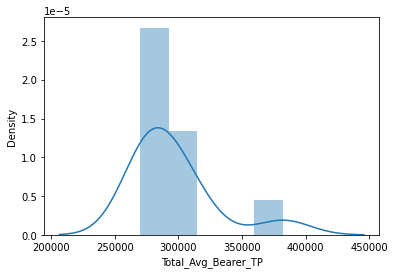

In [37]:
sorted_by_tp = handset_type_agg.sort_values('Total_Avg_Bearer_TP', ascending=False)
top_tp = sorted_by_tp['Total_Avg_Bearer_TP']
 
sns.distplot(top_10)
pd.DataFrame(top_10.describe()) 

#### **Task 3.4.** 
Perform a K-Means clustering (where k = 3) to segment users into groups of experiences.

In [38]:
experiance_metric_df = user_experience[[
    "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP"]].copy()
experiance_metric_df.head()

,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP
MSISDN_Number,,,
33601001722.00,0.05,76.00,3919.15
33601001754.00,0.03,99.00,1119.76
33601002511.00,0.05,97.00,1119.76
33601007832.00,0.08,248.00,366.24
33601008617.00,0.12,56844.00,1858.68


<AxesSubplot:>

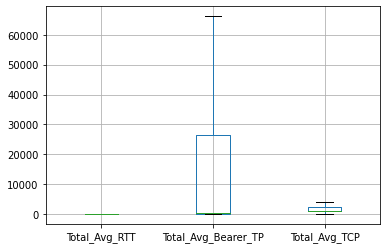

In [39]:
user_experience.boxplot()

In [45]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(experiance_metric_df)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.69,-0.66,1.74
1,-0.93,-0.66,-0.48
2,-0.62,-0.66,-0.48
3,-0.08,-0.66,-1.08
4,0.47,1.78,0.11


In [48]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.35,-0.33,0.88
1,-0.75,-0.54,-0.39
2,-0.61,-0.64,-0.47
3,-0.07,-0.52,-0.85
4,0.26,0.96,0.06
